In [1]:
from tqdm import tqdm
import re

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from flair.data import Sentence
from flair.models import SequenceTagger

In [2]:
# supress matplotlib warning

import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [6]:
# import dataset

FILES = {
    "DNC": "raw/2020 Debate Transcripts.csv",
    "Presidential": "raw/Presidential_debate_USA_final_October_2020.csv",
    "Vice Presidential": "raw/VP_debate_2020.csv",
}

# preview first 5 records

df = pd.read_csv(FILES["Presidential"])
df = df.replace('\n',' ', regex=True)
df.columns = ['RowID', 'Topic', 'Speaker', 'Discourse']
print(df.head())

# explore speakers     

speakers = df['Speaker'].unique()
print('\n distinct speakers: ', speakers)

# clean 'Topics'

df['Topic'] = [text[7:].strip() for text in df['Topic']]

# explore debate topics

topics = df['Topic'].unique()

print('\n debate topics:')
for topic in topics:
    print('\n', topic)

   RowID                Topic Speaker  \
0      1  TOPIC: Introduction  WELKER   
1      2      TOPIC: COVID-19  WELKER   
2      3      TOPIC: COVID-19   TRUMP   
3      4      TOPIC: COVID-19  WELKER   
4      5      TOPIC: COVID-19   BIDEN   

                                           Discourse  
0   A very good evening to both of you. This deba...  
1   And we will begin with the fight against the ...  
2   So, as you know, more 2.2 million people, mod...  
3   OK, former Vice President Biden, to you, how ...  
4   220,000 Americans dead. If you hear nothing e...  

 distinct speakers:  ['WELKER' 'TRUMP' 'BIDEN']

 debate topics:

 Introduction

 COVID-19

 National Security

 Economy

 Immigration

 Race in America

 Climate Change

 Final Question


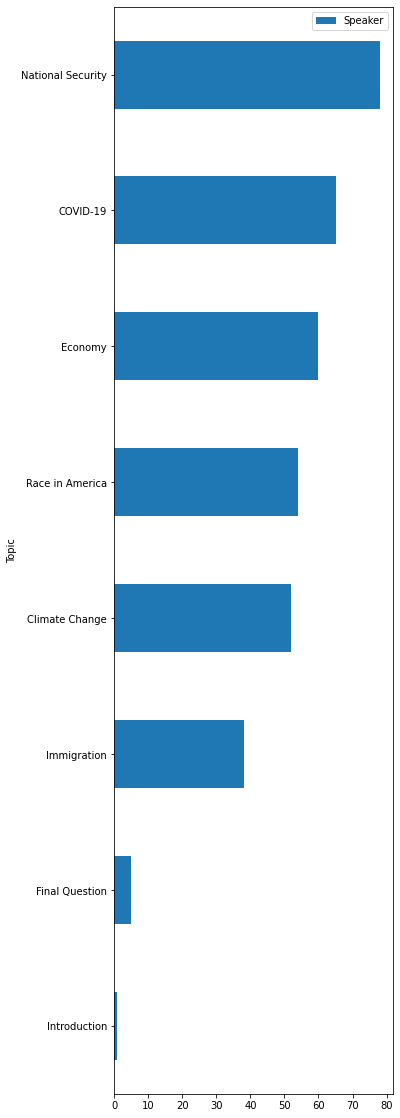

In [7]:
# topics by utterance frequency

speaker_topic = df[['Speaker','Topic']]
speaker_topic.groupby(['Topic']).count().sort_values(by='Speaker').plot(kind='barh', figsize=(5,20));

In [8]:
# check missing values

print("Missing 'Topic' values? \n\n", df.loc[df.Topic.isnull()], "\n\n")
print("Missing 'Speaker' values? \n\n", df.loc[df.Speaker.isnull()], "\n\n")
print("Missing 'Discourse' values? \n\n", df.loc[df.Discourse.isnull()])

Missing 'Topic' values? 

 Empty DataFrame
Columns: [RowID, Topic, Speaker, Discourse]
Index: [] 


Missing 'Speaker' values? 

 Empty DataFrame
Columns: [RowID, Topic, Speaker, Discourse]
Index: [] 


Missing 'Discourse' values? 

 Empty DataFrame
Columns: [RowID, Topic, Speaker, Discourse]
Index: []


## Parsing of discourse into monlogues and dialogues

In [27]:
# parse monologues and dialogues

monologues = df[0:0]
dialogues = df[0:0]

topics = np.delete(df['Topic'].unique(), [0, 7]) # excluding 'Introduction'

for topic in topics:
    # print(df.loc[df['Topic'] == topic])
    tp = df.loc[df['Topic'] == topic]
    m = tp.iloc[1]
    monologues = monologues.append(m)
    
    # determine last record; use idx_last and last to grab remaining discourse on the topic; this constitutes dialogue
    # print(tp.iloc[[-1]].index[0])
    idx_last = tp.iloc[[-1]].index[0]
    dialogues = dialogues.append(tp.iloc[3:idx_last,:])   

# manual parsing of 'COVID-19'
row = dialogues.loc[df['RowID'].isin([5, 54])]
monologues = monologues.append(row, ignore_index=True)
dialogues.drop(row.index, inplace=True)

# manual parsing of 'National Security'
row = dialogues.loc[df['RowID'].isin([98, 127])]
monologues = monologues.append(row, ignore_index=True)
dialogues.drop(row.index, inplace=True)

# manual parsing of 'Economy'
row = dialogues.loc[df['RowID'].isin([148, 190])]
monologues = monologues.append(row, ignore_index=True)
dialogues.drop(row.index, inplace=True)

# manual parsing of 'Climate Change'
row = dialogues.loc[df['RowID'].isin([302, 325])]
monologues = monologues.append(row, ignore_index=True)
dialogues.drop(row.index, inplace=True)

# manual parsing of 'Final Question'    
cs = df.loc[((df['Topic'] == 'Final Question') & (df['Speaker'].isin(['TRUMP', 'BIDEN'])))]
monologues = monologues.append(cs)

# sort both dataframes by RowID
monologues = monologues.sort_values('RowID')
dialogues = dialogues.sort_values('RowID')

# remove leading and trailing spaces
monologues['Discourse'] = [text.strip() for text in monologues['Discourse']]
dialogues['Discourse'] = [text.strip() for text in dialogues['Discourse']]

monologues.rename(columns = {'Discourse': 'Text'}, inplace = True)
dialogues.rename(columns = {'Discourse': 'Text'}, inplace = True)

# print('\n number of monologues: ', len(monologues))
# print('\n\n monologues: \n\n', monologues)
# print('\n\n number of dialogues: ', len(dialogues))
# print('\n\n dialogues: \n\n', dialogues)

## Determine long monologues that should be manually parsed into halves/thirds

In [25]:
# count characters in 'text'; if greater than 1024 put into 'thirds'; else put into 'halves'; manually parse duplicates
halves = []
thirds = []

for row in monologues[['RowID', 'Text']].itertuples():
    if len(row.Text) > 1024:
        thirds.append(row.RowID)
    elif 512 < len(row.Text) < 1024:
        halves.append(row.RowID)

print('\n\n Monologues to be halved: \n\n', halves)
print('\n\n Monologues to be cut in thirds: \n\n',thirds)



 Monologues to be halved: 

 [54, 127, 190, 325, 352]


 Monologues to be cut in thirds: 

 [3, 68, 146, 244, 298, 5, 98, 148, 302, 350]


In [20]:
m = monologues['Text'].tolist()
d = dialogues['Text'].tolist()
print(len(m))
print(len(d))

16
321


## Tag utterances for POS using Flair library

In [21]:
# tag utterances

tagger = SequenceTagger.load('pos-fast')

corpus = d
tagged = []

for i in tqdm(corpus):
  sentence = Sentence(i)
  tagger.predict(sentence)
  tagged.append(sentence.to_tagged_string())

for i in range(1):
  print(tagged[i])
  print(corpus[i])

2021-09-19 13:32:26,706 loading file /home/ebenge/.flair/models/en-pos-ontonotes-fast-v0.5.pt


100%|██████████| 321/321 [02:00<00:00,  2.66it/s]

President <NNP> Trump <NNP> , <,> I <PRP> 'd <MD> like <VB> to <TO> follow <VB> up <RP> with <IN> you <PRP> and <CC> your <PRP$> comments <NNS> . <,> You <PRP> talked <VBD> about <IN> taking <VBG> a <DT> therapeutic <JJ> . <.> I <PRP> assume <VBP> you <PRP> 're <VBP> referencing <VBG> Regeneron <NNP> . <.> You <PRP> also <RB> said <VBD> a <DT> vaccine <NN> will <MD> be <VB> coming <VBG> within <IN> weeks <NNS> . <,> Is <VBZ> that <DT> a <DT> guarantee <NN> ? <.>
President Trump, I'd like to follow up with you and your comments. You talked about taking a therapeutic. I assume you're referencing Regeneron. You also said a vaccine will be coming within weeks. Is that a guarantee?


In [22]:
# extract tags 

for i in tqdm(range(len(tagged))):
  for j in corpus[i].split():
    tagged[i] = str(tagged[i]).replace(j,"",1)

  # remove < > characters
  for j in  ['<','>']:
    tagged[i] = str(tagged[i]).replace(j,"")
    # remove redundant spaces
    tagged[i] = re.sub(' +', ' ', str(tagged[i]))
    tagged[i] = str(tagged[i]).lstrip()

for i in range(1):
  print(tagged[i])
  print(corpus[i])

100%|██████████| 321/321 [00:00<00:00, 7002.50it/s]

NNP Trump NNP , , PRP 'd MD VB TO VB RP IN PRP CC PRP$ comments NNS . , PRP VBD IN VBG DT therpeutic JJ . . I PRP VBP you PRP 're VBP VBG Regeneron NNP . . PRP RB VBD DT NN MD VB VBG IN weeks NNS . , VBZ DT a DT guarantee NN ? .
President Trump, I'd like to follow up with you and your comments. You talked about taking a therapeutic. I assume you're referencing Regeneron. You also said a vaccine will be coming within weeks. Is that a guarantee?


In [23]:
for i in tqdm(range(len(corpus))):
  # remove symbols
  # corpus[i] = re.sub('[^a-zA-Z]', ' ', str(corpus[i]))
  tagged[i] = re.sub('[^a-zA-Z]', ' ', str(tagged[i]))

  ## remove HYPH SYM
  tagged[i] = str(tagged[i]).replace('HYPH',"")
  tagged[i] = str(tagged[i]).replace('SYM',"")                    

  # remove redundant space
  # corpus[i] = re.sub(' +', ' ', str(corpus[i]))
  tagged[i] = re.sub(' +', ' ', str(tagged[i]))

100%|██████████| 321/321 [00:00<00:00, 21604.17it/s]


In [24]:
# check tags 

for i in range(10):
  print('monologue:\n\n'+corpus[i]+'\n') 
  print('tagged:\n\n'+tagged[i]+'\n')
  print('-'*90+'\n')

monologue:

President Trump, I'd like to follow up with you and your comments. You talked about taking a therapeutic. I assume you're referencing Regeneron. You also said a vaccine will be coming within weeks. Is that a guarantee?

tagged:

NNP Trump NNP PRP d MD VB TO VB RP IN PRP CC PRP comments NNS PRP VBD IN VBG DT therpeutic JJ I PRP VBP you PRP re VBP VBG Regeneron NNP PRP RB VBD DT NN MD VB VBG IN weeks NNS VBZ DT a DT guarantee NN 

------------------------------------------------------------------------------------------

monologue:

It is not a guarantee but it will be by the end of the year, but I think it has a good chance. One or two companies, I think, within a matter of weeks, and it will be distributed very quickly.

tagged:

PRP VBZ RB DT NN CC PRP MD VB N DT NN N DT yer NN CC I PRP VBP PRP VBZ DT JJ chance NN CD CC CD companies NNS I PRP think VBP IN a DT NN IN weeks NNS CC PRP MD VB VBN RB quickly RB 

-----------------------------------------------------------------

100%|██████████| 329/329 [00:00<00:00, 160326.02it/s]


Counter({'PRP': 2162, 'NN': 1605, 'IN': 1309, 'DT': 1301, 'VB': 1028, 'RB': 958, 'VBP': 807, 'NNP': 706, 'NNS': 666, 'JJ': 661, 'VBD': 583, 'VBZ': 521, 'CC': 487, 'VBG': 408, 'TO': 392, 'CD': 279, 'VBN': 261, 'I': 246, 'MD': 215, 'N': 179, 'WP': 166, 'RP': 141, 'WRB': 132, 'WDT': 79, 'UH': 71, 'JJR': 57, 'EX': 35, 'NNPS': 28, 'PDT': 27, 'JJS': 24, 'RBR': 17, 'POS': 15, 'OK': 13})


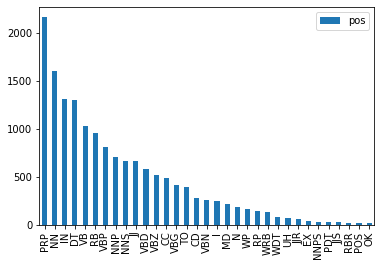

In [62]:
from collections import Counter

# unpack tagged

pos = []

for i in tqdm(range(len(tagged))):
    pos.extend(tagged[i].split())

c = Counter(pos)
count = Counter({k: c for k, c in c.items() if k.isupper() if c > 8})

print(count)

tags = pd.DataFrame().from_dict(count, orient='index')
tags.columns = ['pos']
tags.sort_values(by='pos', ascending=False).plot(kind='bar')
plt.show()

# NN - Noun, singular or mass, PRP - Personal pronoun, DT - Determiner, 
# IN - Preposition or subordinating conjunction, VB - Verb, base form, VBP - Verb, non-3rd person singular present, 
# RB - Adverb, JJ - Adjective, NNS - Noun, plural, NNP - Proper noun, singular, CC - Coordinating conjunction, 
# VBZ - Verb, 3rd person singular present, TO - to, VBG - Verb, gerund or present participle, 
# VBD - Verb, past tense, VBN - Verb, past participle, MD - Modal, CD - Cardinal number, WP - Wh-pronoun, 
# WDT - Wh-determiner, WRB - Wh-adverb, RP - Particle, UH - Interjection, JJR - Adjective, comparative, 
# JJS - Adjective, superlative, NNPS - Proper noun, plural, EX - Existential there, RBR Adverb, comparative, 
# POS - Possessive ending, RRB - ?, FW - Foreign word, RBS - Adverb, superlative, PDT - Predeterminer
# LRB - ?, NFP - Superfluous punctuation

## Write out monologues and dialogues to TSV files

In [28]:
mono_output = monologues[['RowID', 'Topic', 'Speaker','Text']]
dia_output = dialogues[['RowID', 'Topic', 'Speaker','Text']]

mono_output.to_csv('processed/presidential_debate_monologues.tsv', sep = '\t', index=False)
dia_output.to_csv('processed/presidential_debate_dialogues.tsv', sep = '\t', index=False)

## Process TSV files for MLM

The manually parsed monologue dataset is named `presidential_debate_monologues_parsed.tsv`. A copy named `presidential_debate_monologues_for_MLM.tsv` is made in order to preserve the naming convention. 

In [31]:
_df = pd.read_csv('processed/presidential_debate_dialogues.tsv', sep = '\t')
df = _df.sample(n = 41)
df.to_csv('processed/presidential_debate_dialogues_for_MLM.tsv', sep = '\t', index=False)                    

## Process TSV files for NSP

In [36]:
# import dataset

FILES = {
    "Monologue": "processed/presidential_debate_monologues.tsv",
    "Dialogue": "processed/presidential_debate_dialogues.tsv",
}

# preview first 5 records

df = pd.read_csv(FILES["Monologue"], sep = '\t', usecols = ['Topic','Text'])
print(df.head())

      Topic                                               Text
0  COVID-19  So, as you know, more 2.2 million people, mode...
1  COVID-19  And there were some spikes and surges in other...
2  COVID-19  And now they say I'm immune. Whether it's four...
3  COVID-19  220,000 Americans dead. If you hear nothing el...
4  COVID-19  220,000 Americans dead. If you hear nothing el...


In [37]:
topics = df['Topic'].unique().tolist()
text = df[0:0]
text_output = []
# text = pd.DataFrame(columns=['Text'])

for topic in topics:
    tp = df.loc[df['Topic'] == topic]
    for index, row in tp.iterrows():
        sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s", row['Text'])
        for i in range(len(sentences)):
            _row = [topic, sentences[i]]
            _series = pd.Series(_row, index = df.columns)
            text = text.append(_series, ignore_index=True)
            
    _series = pd.Series([np.nan, np.nan], index = df.columns)
    text = text.append(_series, ignore_index=True)
    
print(text.head())

text.to_csv('processed/presidential_debate_monologues_for_NSP.tsv', sep = '\t', index=False)

file = 'processed/presidential_debate_monologues_for_NSP.tsv'

f = open(file, 'r')
text = f.read()
f.close()
text = text.replace("\"\"","")
f = open(file, 'w')
f.write(text)
f.close()

      Topic                                               Text
0  COVID-19  So, as you know, more 2.2 million people, mode...
1  COVID-19  We closed up the greatest economy in the world...
2  COVID-19                         It's a worldwide pandemic.
3  COVID-19                           It’s all over the world.
4  COVID-19  You see the spikes in Europe and many other pl...


In [38]:
topics = df['Topic'].unique().tolist()
print(topics)

['COVID-19', 'National Security', 'Economy', 'Immigration', 'Race in America', 'Climate Change', 'Final Question']


At this point I take half of the topics from the dialogue dataset and combine them with the other half of the topics from the monologue dataset. This makes up the training dataset. The inverse topics are then selection from the inverse datasets and this makes up the validation dataset. Each topic constitutes a 'document' in the setting of next sentence prediction. The resulting datasets are named `presidential_debate_train_for_NSP.tsv` and `presidential_debate_val_for_NSP.tsv`.

## Process TSV files for SeqClassif

I take half of the topics from the dialogue dataset and combine them with the other half of the topics from the monologue dataset. This makes up the training dataset. The inverse topics are then selection from the inverse datasets and this makes up the validation dataset. Utterances/Sentences from the monologue dataset are given the label 0 and those from the dialogue dataset are given the label 1. from Extra examples are deleted in order to maintain balanced training and validation datasets. The resulting datasets are named `presidential_debate_train_for_SC.tsv` and `presidential_debate_val_for_SC.tsv`.

In [3]:
# import dataset

FILES = {
    "Monologue": "processed/presidential_debate_monologues.tsv",
    "Dialogue": "processed/presidential_debate_dialogues.tsv",
}

# preview first 5 records

df = pd.read_csv(FILES["Dialogue"], sep = '\t', usecols = ['Topic','Text'])
print(df.head())

      Topic                                               Text
0  COVID-19  220,000 Americans dead. If you hear nothing el...
1  COVID-19  President Trump, I'd like to follow up with yo...
2  COVID-19  It is not a guarantee but it will be by the en...
3  COVID-19                    Can you tell us what companies?
4  COVID-19  Johnson and Johnson is doing very well. Modern...
